# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

## Подготовка данных

### Загрузка данных.  

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb

Прочитаем и сохраним данные в переменную `df`

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

Посмотрим на общую информацию о данных

In [3]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Описание данных  

Признаки  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

Целевой признак  
Price — цена (евро)  

Видно, что в таблице данные разных типов, имеются пропуски в некоторых столбцах. Посмотрим на сводную информацию по числовым признакам

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Заметны аномальные значения, например цена равная `0` или год регистрации `9999`. Также видно, что столбец `NumberOfPictures` содержит только одно уникальное значение.  

Переходим к предобработке

### Пропуски

Посчитаем количество пропусков

In [5]:
df.isna().mean()*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Пропуски содержатся в пяти столбцах, все столбцы с категориальными признаками. Больше всего пропусков в столбце с информацией о ремонте. Заменим пропущенные значения в этом столбце на `unknown`

In [6]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

Остальные пропуски заполнять не будем, во-первых, так как их не много (10% и меньше), во-вторых, потому что типы топлива, кузова и коробки передач могут отличатся у одинаковых моделей.  
Удалим оставшиеся пропуски

In [7]:
df = df.dropna()
df.shape

(284126, 16)

### Выбросы

Обработаем выбросы и аномальные значения в числовых признаках. Посмотрим остались ли они после удаления пропусков


In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,284126.000000,284126.000000,284126.000000,284126.000000,284126.000000,284126.0,284126.000000
mean,4847.265516,2002.567861,117.727213,128261.651521,6.071577,0.0,51094.901026
std,4637.056831,6.243808,169.107292,36739.971043,3.548155,0.0,25775.683653
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30851.000000
50%,3199.000000,2003.000000,109.000000,150000.000000,6.000000,0.0,50170.000000
75%,6999.000000,2007.000000,147.000000,150000.000000,9.000000,0.0,71706.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Выбросы остались. Начнем с цены

#### Цена

Минимальное значение `0`, максимальное `20000`. Можно допустить, что в данных имеются очень дорогие автомобили, но минимальная цена должна быть точно больше нуля. Проверим с помощью гистограммы распределение авто с ценой меньше 100 евро

<AxesSubplot:>

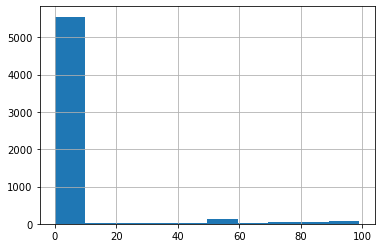

In [9]:
df[df['Price']<100]['Price'].hist()

Заметно, что ненулевая цена ниже 50 евро, встречается очень редко. Поэтому удалим строки с объектами с ценой менее 50 евро

In [10]:
df = df.query('Price >= 50')
df.shape

(278501, 16)

#### Год регистрации

Построим боксплот по году регистрации

<AxesSubplot:>

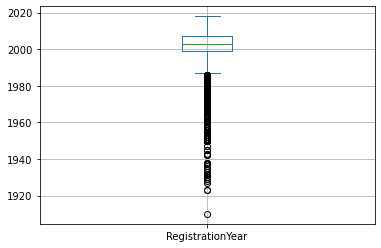

In [11]:
df['RegistrationYear'].plot(kind='box', grid=True)

Приблизим нижнюю границу

(1980.0, 1990.0)

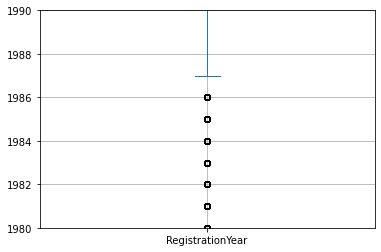

In [12]:
df['RegistrationYear'].plot(kind='box', grid=True)
plt.ylim(1980, 1990)

Удалим все объекты с годом регистрации меньше `1987`

In [13]:
df = df.query('1987 <= RegistrationYear < 2016')
df.shape

(274474, 16)

#### Мощность

Минимальное значение `0`, максимальное `20000`. Оба значения выглядят нереальными. Найдем верхнюю границу допустимых значений мощности. Построим диаграмму размаха для авто с мощьностью менее `1000` л.с. (так как всё, что выше `1000` л.с. очевидно выбросы)

(0.0, 1000.0)

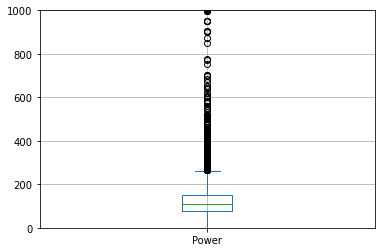

In [15]:
df['Power'].plot(kind='box', grid=True)
plt.ylim(0, 1000)

Заметно, что мощность выше `600` л.с. встречается редко.  
Посмотрим на авто с мощностью меньше `100` л.с.

<AxesSubplot:>

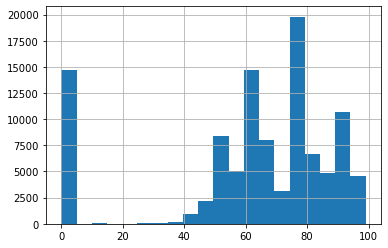

In [16]:
df[df['Power']<100]['Power'].hist(bins=20)

Оснавная часть машин с мощьностью двигателя более `40` л.с.  

Оставим для дальнейшего исследования автомобили с мощностью двигателя от `40` до `600` л.с.

In [17]:
df = df.query('40<=Power<=600')
df.shape

(259165, 16)

#### Пробег

Проверим уникальные значения пробега

In [18]:
df['Kilometer'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

Уникальных значений 13, и по их значениям можно утверждать, что данный столбец содержит категориальный признак, а не числовой.

#### Месяц регистрации

Посмотрим на уникальные значения

In [19]:
df['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Значения от `0` до `12`, возможно `0` означает, что месяц регистрации неизвестен. Признак тоже категориальный

#### Количество фотографий

Столбец содержит только одно уникальное значение и для нашего исследования будет бесполезен

#### Почтовый индекс

Очевидно категориальный признак, а не числовой

### Дубликаты

Проверим наличие дубликатов

In [20]:
df.duplicated().sum()

4

Удалим дубликаты

In [21]:
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(259161, 16)

### Замена типа данных

Заменим у категориальных признаков тип данных на `category`

In [22]:
df[['VehicleType', 'Gearbox', 'Model', 'Kilometer', 
    'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']] = (
    df[['VehicleType', 'Gearbox', 'Model', 'Kilometer', 
        'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']].astype('category'))

In [23]:
df.dtypes

DateCrawled            object
Price                   int64
VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                   int64
Model                category
Kilometer            category
RegistrationMonth    category
FuelType             category
Brand                category
NotRepaired          category
DateCreated            object
NumberOfPictures        int64
PostalCode           category
LastSeen               object
dtype: object

### Выборки

Подготовим выборки для обучения моделей

In [24]:
X = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'Price'], axis=1)
y = df['Price']

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=2323)

In [26]:
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=2323)

In [27]:
display(X_train.shape[0])
display(X_valid.shape[0])
display(X_test.shape[0])

155496

51833

51832

In [28]:
display(X_train.head(3))
display(X_valid.head(3))
display(X_test.head(3))

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
178104,small,2007,manual,90,corsa,150000,12,petrol,opel,no,65199
250080,suv,2012,manual,163,other,70000,4,gasoline,chevrolet,no,26209
65753,small,1996,manual,75,golf,150000,8,petrol,volkswagen,unknown,41063


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
92017,small,2013,manual,75,corsa,150000,0,gasoline,opel,no,22309
71577,sedan,2007,auto,235,5er,125000,8,gasoline,bmw,no,21423
140662,wagon,2001,auto,130,passat,150000,3,gasoline,volkswagen,unknown,28207


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
54674,sedan,1999,manual,116,focus,150000,8,petrol,ford,no,12689
131563,wagon,2003,manual,131,a4,150000,8,petrol,audi,no,36088
2267,wagon,2001,manual,136,3er,150000,10,gasoline,bmw,yes,61381


**Вывод:** 
Данные подготовленны для обучения моделей:

* устранены пропуски, выбросы и дубликаты
* заменены типы данных у категориальных признаков
* данные разделены на выборки

## Обучение моделей

Будем обучать модели градиентного бустинга LightGBM и CatBoost

### LightGBM

Обучем модель с гиперпараметрами по умолчанию

In [29]:
booster = lgb.LGBMRegressor(objective='regression_l2',
                            random_seed=223,
                            #learning_rate=0.1,
                            #n_estimators=100,
                            #max_depth=-1
                            )

In [30]:
%%time
booster.fit(X_train, 
            y_train,
            eval_set=[(X_valid, y_valid),],
            eval_metric='rmse',
            verbose=20
           )

C:\Users\Keys\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Keys\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Keys\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[20]	valid_0's rmse: 1831.95	valid_0's l2: 3.35605e+06
[40]	valid_0's rmse: 1573.6	valid_0's l2: 2.4762e+06
[60]	valid_0's rmse: 1538.84	valid_0's l2: 2.36802e+06
[80]	valid_0's rmse: 1527.21	valid_0's l2: 2.33238e+06
[100]	valid_0's rmse: 1520.56	valid_0's l2: 2.31209e+06
Wall time: 1.35 s


LGBMRegressor(objective='regression_l2', random_seed=223)

Лучший результат модель показала на последней итерации, вероятно она недоучилась. Увеличим количество итераций и скорость обучения

In [31]:
booster1 = lgb.LGBMRegressor(objective='regression_l2',
                             random_seed=223,
                             learning_rate=0.2,
                             n_estimators=1500,
                             #max_depth=-1
                             )

In [32]:
%%time
booster1.fit(X_train, 
             y_train,
             eval_set=[(X_valid, y_valid),],
             eval_metric='rmse',
             verbose=300
            )

[300]	valid_0's rmse: 1508.81	valid_0's l2: 2.2765e+06
[600]	valid_0's rmse: 1505.22	valid_0's l2: 2.26568e+06
[900]	valid_0's rmse: 1504.91	valid_0's l2: 2.26476e+06
[1200]	valid_0's rmse: 1504.8	valid_0's l2: 2.26444e+06
[1500]	valid_0's rmse: 1506.45	valid_0's l2: 2.2694e+06
Wall time: 10.8 s


LGBMRegressor(learning_rate=0.2, n_estimators=1500, objective='regression_l2',
              random_seed=223)

Значения метрики на последних итерациях стали увеличиваться, можно утверждать, что модель обучилась

### CatBoost

Обучим модель с гиперпараметрами по умолчанию

In [33]:
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=[0,2,4,5,6,7,8,9,10]
                 )

valid_pool = Pool(X_valid,
                  y_valid,
                  cat_features=[0,2,4,5,6,7,8,9,10]
                 )

In [34]:
cat = CatBoostRegressor(#iterations=1000,
                        #learning_rate=0.33,
                        #depth=6,
                        random_seed=223,
                        loss_function='RMSE'
                       )                        

In [35]:
%%time
cat.fit(train_pool,
        verbose=100,
        eval_set=valid_pool,
        #plot=True
       )

Learning rate set to 0.112459
0:	learn: 4277.5721058	test: 4310.8275045	best: 4310.8275045 (0)	total: 335ms	remaining: 5m 34s
100:	learn: 1594.2041175	test: 1605.2144108	best: 1605.2144108 (100)	total: 22s	remaining: 3m 15s
200:	learn: 1526.4031778	test: 1550.3277795	best: 1550.3277795 (200)	total: 44.5s	remaining: 2m 56s
300:	learn: 1493.0464852	test: 1526.5393383	best: 1526.5393383 (300)	total: 1m 5s	remaining: 2m 32s
400:	learn: 1471.2014462	test: 1511.4006033	best: 1511.4006033 (400)	total: 1m 29s	remaining: 2m 13s
500:	learn: 1454.8570451	test: 1502.0262116	best: 1502.0262116 (500)	total: 1m 50s	remaining: 1m 50s
600:	learn: 1441.7269433	test: 1495.2053564	best: 1495.2053564 (600)	total: 2m 13s	remaining: 1m 28s
700:	learn: 1430.1182041	test: 1489.3611417	best: 1489.3611417 (700)	total: 2m 36s	remaining: 1m 6s
800:	learn: 1420.7865549	test: 1484.9531727	best: 1484.9531727 (800)	total: 2m 59s	remaining: 44.5s
900:	learn: 1410.4591169	test: 1480.8980433	best: 1480.8980433 (900)	tota

Лучший результат модель показала на 998 из 1000 итераций, вероятно модель недообучилась. Увеличим скорость обучения и глубину деревьев

In [36]:
cat1 = CatBoostRegressor(#iterations=1000,
                         learning_rate=0.35,
                         depth=8,
                         random_seed=223,
                         loss_function='RMSE'
                        )

In [37]:
%%time
cat1.fit(train_pool,
         verbose=100,
         eval_set=valid_pool,
         plot=True
        )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3496.4603963	test: 3528.2830755	best: 3528.2830755 (0)	total: 269ms	remaining: 4m 28s
100:	learn: 1430.8896413	test: 1500.1795082	best: 1500.1795082 (100)	total: 29s	remaining: 4m 18s
200:	learn: 1361.4811937	test: 1478.9151673	best: 1478.9151673 (200)	total: 1m 1s	remaining: 4m 2s
300:	learn: 1310.8014128	test: 1468.9236073	best: 1468.8840533 (297)	total: 1m 32s	remaining: 3m 35s
400:	learn: 1271.0536998	test: 1464.0395343	best: 1463.9037628 (398)	total: 2m 6s	remaining: 3m 9s
500:	learn: 1234.7487893	test: 1462.2689711	best: 1462.2689711 (500)	total: 2m 41s	remaining: 2m 40s
600:	learn: 1203.1537311	test: 1463.0657975	best: 1461.8175194 (507)	total: 3m 16s	remaining: 2m 10s
700:	learn: 1176.5899694	test: 1463.2922512	best: 1461.8175194 (507)	total: 3m 50s	remaining: 1m 38s
800:	learn: 1152.9783542	test: 1464.4464194	best: 1461.8175194 (507)	total: 4m 25s	remaining: 1m 5s
900:	learn: 1127.9880427	test: 1466.4015300	best: 1461.8175194 (507)	total: 5m 2s	remaining: 33.2s
999:	

Лучшее значение метрики перестало изменяться, соответственно модель обучилась

### RandomForest

Обучим модель случайного леса

In [38]:
encoder = OrdinalEncoder()
X_train_ordinal = pd.DataFrame(encoder.fit_transform(X_train), 
                                                      columns=X_train.columns)
X_valid_ordinal = pd.DataFrame(encoder.fit_transform(X_valid), 
                                                      columns=X_valid.columns)
X_test_ordinal = pd.DataFrame(encoder.fit_transform(X_test), 
                                                      columns=X_test.columns)

In [41]:
%%time
model_rf = RandomForestRegressor(random_state=23, n_estimators=150, max_depth=50)
model_rf.fit(X_train_ordinal, y_train)

Wall time: 1min 22s


RandomForestRegressor(max_depth=50, n_estimators=150, random_state=23)

In [43]:
preds_rf_valid = model_rf.predict(X_valid_ordinal)
rmse_rf_valid = mean_squared_error(y_valid, preds_rf_valid, squared=False)
rmse_rf_valid

1584.977531168892

## Анализ моделей

Проанализируем работу моделей на тестовой выборке

### LightGBM

Сделаем предсказания, расчитаем RMSE и замерим время

In [44]:
%%time
preds_lgb_test = booster1.predict(X_test)
rmse_lgb_test = mean_squared_error(y_test, preds_lgb_test, squared=False)
rmse_lgb_test

Wall time: 3.15 s


1501.0787454847334

### CatBoost

Сделаем предсказания, расчитаем RMSE и замерим время

In [45]:
test_pool = Pool(X_test, 
                 cat_features=[0,2,4,5,6,7,8,9,10])

In [46]:
%%time
preds_cat_test = cat1.predict(test_pool)
rmse_cat_test = mean_squared_error(y_test, preds_cat_test, squared=False)
rmse_cat_test

Wall time: 234 ms


1468.6211278269716

### RandomForest

Сделаем предсказания, расчитаем RMSE и замерим время

In [47]:
%%time
preds_rf_test = model_rf.predict(X_test_ordinal)
rmse_rf_test = mean_squared_error(y_test, preds_rf_test, squared=False)
rmse_rf_test

Wall time: 3.11 s


1599.169490078581

### Сравнение

Соберём в одну таблицу полученные данные

In [48]:
pivot_data = pd.DataFrame(index=['LightGBM','CatBoost', 'RandomForest'],
                         columns=['time_train, s','rmse','time_pred, ms'],
                         data=[[12, 1506, 3014],
                               [60*5+42, 1475, 314],
                              [60*1+22, 1599, 3003]]
                         )
pivot_data

,"time_train, s",rmse,"time_pred, ms"
LightGBM,12,1506,3014
CatBoost,342,1475,314
RandomForest,82,1599,3003


**Вывод:**  

Из сводной таблицы видно, что хоть модель `CatBoost` дольше обучается, качество и скорость предсказаний у нее лучше. Поэтому рекомендую использовать `CatBoost`.
